In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import librosa as lb
import os

In [3]:
patient_data=pd.read_csv('/content/drive/MyDrive/Respiratory sound analysis, classification and disease detection (Final Year Design Project)/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [4]:
path='/content/drive/MyDrive/Respiratory sound analysis, classification and disease detection (Final Year Design Project)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
path
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['162_2b2_Ar_mc_AKGC417L',
 '162_2b2_Pl_mc_AKGC417L',
 '162_1b2_Pr_mc_AKGC417L',
 '162_2b2_Al_mc_AKGC417L',
 '162_2b3_Pr_mc_AKGC417L']

In [5]:
def getFilenameInfo(file):
    return file.split('_')

In [6]:
def extractId(filename):
    return filename.split('_')[0]

In [7]:
path='/content/drive/MyDrive/Respiratory sound analysis, classification and disease detection (Final Year Design Project)/Respiratory_Sound_Database/Respiratory_Sound_Database/processed_audio_files/'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

,pid,filename
0,151,151_2p2_Ar_mc_AKGC417L_3.wav
1,151,151_2p2_Ar_mc_AKGC417L_4.wav
2,151,151_2p2_Ar_mc_AKGC417L_5.wav
3,151,151_2p3_Ll_mc_AKGC417L_0.wav
4,151,151_2p3_Ll_mc_AKGC417L_1.wav


In [8]:
patient_data

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [9]:
files_df['pid'] = pd.to_numeric(files_df['pid'], errors='coerce')
#files_df.pid = files_df.pid.astype('int64')
data = pd.merge(files_df, patient_data, on='pid')
data.head()
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [10]:
data.shape

(6898, 3)

#Trimming the two classes with least example

In [17]:
data.drop(data[data['disease'] == 'LRTI'].index, inplace = True)

In [18]:
data.drop(data[data['disease'] == 'Asthma'].index, inplace = True)

In [19]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

In [20]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.837512
Healthy           0.047036
Pneumonia         0.041594
URTI              0.035374
Bronchiolitis     0.023324
Bronchiectasis    0.015160
Name: disease, dtype: float64

In [21]:
Xval.disease.value_counts()/Xval.shape[0]

COPD              0.837901
Healthy           0.046647
Pneumonia         0.041399
URTI              0.035569
Bronchiolitis     0.023324
Bronchiectasis    0.015160
Name: disease, dtype: float64

In [22]:
train=pd.read_csv('/content/drive/MyDrive/Respiratory sound analysis, classification and disease detection (Final Year Design Project)/Respiratory_Sound_Database/Respiratory_Sound_Database/processed_audio_files/train.csv')
val=pd.read_csv('/content/drive/MyDrive/Respiratory sound analysis, classification and disease detection (Final Year Design Project)/Respiratory_Sound_Database/Respiratory_Sound_Database/processed_audio_files/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1542,124,124_1b1_Pl_sc_Litt3200_6.wav,COPD
1,3744,194,194_1b1_Pr_sc_Meditron_6.wav,Healthy
2,473,130,130_2b2_Ar_mc_AKGC417L_7.wav,COPD
3,5073,179,179_1b1_Al_sc_Meditron_3.wav,Healthy
4,1332,175,175_1b1_Al_sc_Litt3200_2.wav,COPD


In [23]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

In [24]:
ytrain.shape

(5173,)

In [25]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [26]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)
    rms=lb.feature.rms(y=soundArr)
    return mfcc,cstft,mSpec,rms

In [27]:
root='/content/drive/MyDrive/Respiratory sound analysis, classification and disease detection (Final Year Design Project)/Respiratory_Sound_Database/Respiratory_Sound_Database/processed_audio_files/'
mfcc,cstft,mSpec,rms=[],[],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c,d=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    rms.append(d)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)
rms_val=np.array(rms)

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
root='/content/drive/MyDrive/Respiratory sound analysis, classification and disease detection (Final Year Design Project)/Respiratory_Sound_Database/Respiratory_Sound_Database/processed_audio_files/'
mfcc,cstft,mSpec,rms=[],[],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c,d=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    rms.append(d)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)
rms_train=np.array(rms)

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout,Reshape,Multiply,ConvLSTM2D,Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM
from keras.activations import *
from keras import backend as K

In [ ]:
def squeeze_excite_block(inputs, ratio=16):
    init = inputs       ## (b, 128, 128, 32)
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = tf.keras.layers.GlobalMaxPool2D()(init)     ## (b, 32)   -> (b, 1, 1, 32)
    se = Reshape(se_shape)(se)
    se = Dense(filters//ratio, activation="relu", use_bias=False)(se)
    se = Dense(filters, activation="sigmoid", use_bias=False)(se)

    x = Multiply()([inputs, se])
    return x

In [ ]:
checkpoint=ModelCheckpoint(r'net_eval',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          save_weights_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0.001,
                       patience=20,
                       verbose=1,
                       restore_best_weights=True)
my_callbacks=[checkpoint,earlystop]

In [ ]:
print(mfcc_train.shape)


(5173, 20, 259)


In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")

x=keras.layers.Conv2D(32,3,strides=(1,2),padding='same')(mfcc_input)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='same')(x)

x=keras.layers.Conv2D(64,2,padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(256,2,padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)

x=keras.layers.LSTM(64,return_sequences=True)(squeezed)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
mfcc_output=keras.layers.GlobalMaxPooling1D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfccInput (InputLayer)         [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 20, 130, 32)  320         ['mfccInput[0][0]']              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 32)          0           ['conv2d[0][0]']                 
 xPooling2D)                                                                                      
                                                                                          

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,3,strides=(1,2),padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)



squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)
x=keras.layers.LSTM(64,return_sequences=True)(squeezed)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
croma_output=keras.layers.GlobalMaxPooling1D()(x)



croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cromaInput (InputLayer)        [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 12, 87, 32)   832         ['cromaInput[0][0]']             
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 32)          0           ['conv2d_4[0][0]']               
 MaxPooling2D)                                                                                    
                                                                                         

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,4,padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=3,padding='valid')(x)

x=keras.layers.Conv2D(128,4,padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)
x=keras.layers.LSTM(64,return_sequences=True)(squeezed)

x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output =keras.layers.GlobalMaxPooling1D()(x)
mSpec_output =keras.layers.Dense(32)(mSpec_output)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mSpecInput (InputLayer)        [(None, 128, 259, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 87, 32)   832         ['mSpecInput[0][0]']             
                                                                                                  
 global_max_pooling2d_7 (Global  (None, 32)          0           ['conv2d_7[0][0]']               
 MaxPooling2D)                                                                                    
                                                                                         

In [ ]:
rms_input=keras.layers.Input(shape=(1,259,1),name="rmsInput")
x=keras.layers.Conv2D(32,3,strides=(1,2),padding='same')(rms_input)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=1,padding='valid')(x)

x=keras.layers.Conv2D(64,2,strides=(1,2),padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=1,padding='valid')(x)

x=keras.layers.Conv2D(96,2,strides=(1,2),padding='same')(x)
#x = squeeze_excite_block(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
x=keras.layers.MaxPooling2D(pool_size=1,padding='valid')(x)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)
x=keras.layers.LSTM(32,return_sequences=True)(squeezed)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.elu)(x)
rms_output = keras.layers.GlobalMaxPooling1D()(x)

rms_model=keras.Model(rms_input, rms_output, name="rmsModel")

In [ ]:
rms_model.summary()

Model: "rmsModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rmsInput (InputLayer)          [(None, 1, 259, 1)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 1, 130, 32)   320         ['rmsInput[0][0]']               
                                                                                                  
 global_max_pooling2d_11 (Globa  (None, 32)          0           ['conv2d_11[0][0]']              
 lMaxPooling2D)                                                                                   
                                                                                                  
 reshape_11 (Reshape)           (None, 1, 1, 32)     0           ['global_max_pooling2d_11[

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)

input_rms=keras.layers.Input(shape=(1,259,1),name="rms")
rms=rms_model(input_rms)


concat=keras.layers.concatenate([mfcc,croma,mSpec,rms])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(32,activation='elu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(16,activation='elu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec,input_rms], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train,"rms":rms_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val},yval),
    epochs=200
    #callbacks=my_callbacks
)

Epoch 1/200
162/162 [==============================] - 142s 699ms/step - loss: 0.6526 - accuracy: 0.8038 - val_loss: 1.5457 - val_accuracy: 0.4707
Epoch 2/200
162/162 [==============================] - 110s 683ms/step - loss: 0.4360 - accuracy: 0.8508 - val_loss: 0.8549 - val_accuracy: 0.6945
Epoch 3/200
162/162 [==============================] - 109s 673ms/step - loss: 0.3841 - accuracy: 0.8672 - val_loss: 0.4904 - val_accuracy: 0.8400
Epoch 4/200
162/162 [==============================] - 111s 686ms/step - loss: 0.3600 - accuracy: 0.8732 - val_loss: 0.5055 - val_accuracy: 0.8110
Epoch 5/200
162/162 [==============================] - 107s 660ms/step - loss: 0.3284 - accuracy: 0.8811 - val_loss: 0.4269 - val_accuracy: 0.8597
Epoch 6/200
162/162 [==============================] - 111s 686ms/step - loss: 0.3157 - accuracy: 0.8869 - val_loss: 0.3718 - val_accuracy: 0.8730
Epoch 7/200
162/162 [==============================] - 113s 702ms/step - loss: 0.2890 - accuracy: 0.8927 - val_loss: 0

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss and Validation Loss ')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy and Validation Accuracy ')
plt.legend();
plt.show()


NameError: ignored

In [ ]:
net.evaluate({"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train,"rms":rms_train},ytrain)
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val},yval)

48/48 [==============================] - 7s 155ms/step - loss: 0.2398 - accuracy: 0.9148


[0.23978084325790405, 0.9147952198982239]

142/142 [==============================] - 25s 177ms/step
0.9235896870868224
0.999923332481472
0.9895613062016847
0.9977671223383059
0.982443640398714
0.9847462003836506
0.9975650251993134
0.9765517716391375


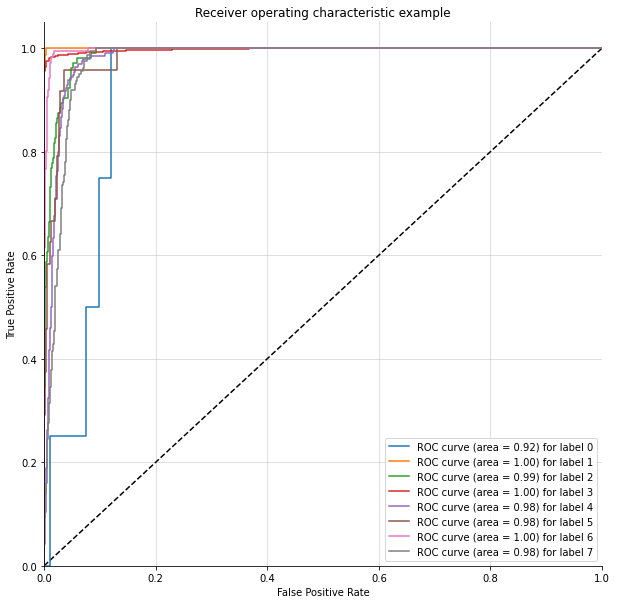

48/48 [==============================] - 7s 153ms/step
0.8257275132275133
0.995159361968915
0.9718998410174882
0.9921026300743281
0.9705367096671444
0.9779216467463479
0.9912581728858867
0.9692379218162799


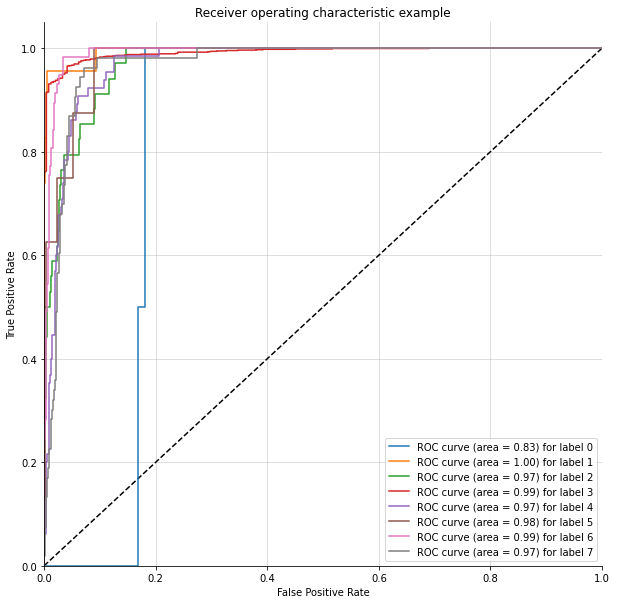

In [ ]:
from sklearn.metrics import roc_curve,auc
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(roc_auc[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.5)
    sns.despine()
    plt.show()

plot_multiclass_roc(net, {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train,"rms":rms_train}, ytrain, n_classes=8, figsize=(10, 10))
plot_multiclass_roc(net, {"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val}, yval, n_classes=8, figsize=(10, 10))

48/48 [==============================] - 10s 202ms/step


array([[2.96717939e-08, 2.86238699e-09, 1.49848967e-10, ...,
        3.09462664e-11, 1.38216016e-09, 1.12380439e-12],
       [1.87036679e-08, 1.03248077e-09, 1.23158275e-10, ...,
        1.90157265e-11, 1.98240271e-10, 7.96942265e-13],
       [1.57531375e-07, 4.03563654e-08, 3.72464948e-09, ...,
        4.41713416e-10, 2.25233023e-08, 5.85058807e-11],
       ...,
       [9.73795089e-09, 2.54023663e-10, 1.41912775e-11, ...,
        4.56666432e-12, 1.34554520e-10, 4.38732675e-14],
       [7.03536998e-08, 3.65844488e-09, 5.93005645e-10, ...,
        7.19210871e-11, 1.05951459e-09, 4.49421880e-12],
       [1.25989247e-10, 5.00604853e-12, 3.04989053e-13, ...,
        2.48544183e-14, 1.06292924e-13, 3.93614014e-16]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = net.predict({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val,"rms":rms_val})

y_pred = np.argmax(y_pred,axis=1)
confusion = confusion_matrix(yval, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(yval, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(yval, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(yval, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(yval, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(yval, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(yval, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(yval, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(yval, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(yval, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(yval, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(yval, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8']))

48/48 [==============================] - 8s 172ms/step
Confusion Matrix

[[   0    0    0    2    0    0    0    0]
 [   0   20    0    2    0    0    0    1]
 [   0    1   17    5    1    0    3    7]
 [   0    2    0 1249    2    0   19    0]
 [   0    3    4    7   36    0    6    9]
 [   0    0    2    0    1    0    2    3]
 [   0    0    0    7    1    0   49    0]
 [   0    0   13    3   21    1    1   14]]

Accuracy: 0.91

Micro Precision: 0.91
Micro Recall: 0.91
Micro F1-score: 0.91

Macro Precision: 0.48
Macro Recall: 0.50
Macro F1-score: 0.49

Weighted Precision: 0.91
Weighted Recall: 0.91
Weighted F1-score: 0.91

Classification Report

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00         2
     Class 2       0.77      0.87      0.82        23
     Class 3       0.47      0.50      0.49        34
     Class 4       0.98      0.98      0.98      1272
     Class 5       0.58      0.55      0.57        65
     Class 6       

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetr